## Multi-step forecasting: recursive approach

We want to predict / forecast multiple steps ahead

* Use forecasted output as new input.
* Recursively apply a 1-step ahead forecast model

In recursive approach we have only only 1 time series model.
* Each forecasting point is estimated using previous forecasts.
* More code to take the forecasts as inputs, and re-create the features.

#### CONS
* Error propagates
* Code complexity
* Inputs are forecast

#### PROS
* Only one model
* Less computation time


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, MultiTaskLasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures

## Load the data

In [24]:
df = pd.read_csv('../../Datasets/AirQualityUCI_ready.csv', 
parse_dates=['Date_Time'], index_col=['Date_Time'], usecols=['CO_sensor','RH', 'Date_Time'])

df.sort_index(inplace=True)

df=df.loc["2004-04-01":"2005-04-30"]

df = df.loc[df['CO_sensor']>0]

# Add missing timestamps (easier for the demo)
df = df.asfreq('1H')

# fill missing
df = df.fillna(method='ffill')

df.head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


## Feature Engineering Pipeline

In [25]:
date_feat = DatetimeFeatures(variables='index', 
features_to_extract=['hour','month', 'week' ,'weekend','day_of_week','day_of_month'])

cyclic_feat = CyclicalFeatures(variables=['hour','month'])

lag_feat = LagFeatures(variables=['CO_sensor', 'RH'], freq=['1H', '24H'], missing_values='ignore')

window_feat = WindowFeatures(variables=['CO_sensor', 'RH'], window='3H' ,freq='1H', missing_values='ignore')

drop_missing = DropMissingData()

drop_feat = DropFeatures(features_to_drop=['CO_sensor','RH'])

pipe = Pipeline([ 
    ('date', date_feat),
    ('cyclic', cyclic_feat),
    ('lag', lag_feat),
    ('window', window_feat),
    ('drop missing', drop_missing),
    ('drop features', drop_feat)
])

## Train Test Split

In [26]:
train = df.loc[df.index < "2005-03-04"]
test = df.loc[pd.to_datetime("2005-03-04")-pd.Timedelta(value='24H'):]

y_train = df.loc[train.index,['CO_sensor','RH']]
y_test = df.loc[test.index,['CO_sensor','RH']]

print('Train Start Date: ',train.index.min(), 'End Date :', train.index.max())
print('Test Start Date: ',test.index.min(), 'End Date :', test.index.max())

Train Start Date:  2004-04-04 00:00:00 End Date : 2005-03-03 23:00:00
Test Start Date:  2005-03-03 00:00:00 End Date : 2005-04-04 14:00:00


## Apply Feature Engineering

In [27]:
X_train = pipe.fit_transform(train)


y_train = y_train.loc[X_train.index]


## Modeling - Lasso


In [28]:
from sklearn.multioutput import MultiOutputRegressor

lasso = MultiOutputRegressor(Lasso())
lasso.fit(X_train, y_train)

MultiOutputRegressor(estimator=Lasso())

## Forecasting 24 hours forward - step by step

First, we will obtain a forecast for the first 24 hours in the test set.

In [29]:
forecast_start = test.index.min() + pd.Timedelta(value='24H')
forecast_end = forecast_start + pd.Timedelta(value='23H')
print('Forecast \nStart :',forecast_start, '\nEnd :',forecast_end)

Forecast 
Start : 2005-03-04 00:00:00 
End : 2005-03-04 23:00:00


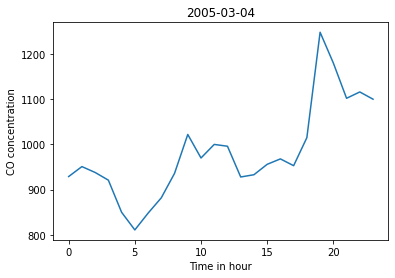

In [30]:
# The timestamps at which we want to predict
# CO concentration.

index = pd.date_range(start=forecast_start, end=forecast_end, freq='1H')

plt.plot(index.hour, y_test.loc[forecast_start:forecast_end,['CO_sensor']]);
plt.title(f'{forecast_start.date()}');
plt.xlabel('Time in hour');
plt.ylabel('CO concentration');

In [31]:
# The forecasting df - dataframe to collect predictions
forecast_df = pd.DataFrame(index=index, columns=["Forecast_CO_sensor", "Forecast_RH"])


## Forecast 1 hour forward

We will create a dataframe that contains the necessary data to make the first point of forecast.

In [32]:
# We are using 24hr-lag-feature so we need 24Hrs of data prior to Forecast-point
# ie to forecast 2005-03-04 00:00:00  we need data from 2005-03-03 00:00:00 to 2005-03-03 23:00:00
date_starting_from = forecast_start-pd.Timedelta(value='24H')

input_data = test.loc[date_starting_from:forecast_start].copy()
input_data.loc[forecast_start] = np.nan
print('Input data Date start :',input_data.index.min(), 'Date end :', input_data.index.max() )



print('Number of rows in the dataframe', len(input_data))
input_data.tail()

Input data Date start : 2005-03-03 00:00:00 Date end : 2005-03-04 00:00:00
Number of rows in the dataframe 25


,CO_sensor,RH
Date_Time,,
2005-03-03 20:00:00,1396.0,84.0
2005-03-03 21:00:00,1285.0,83.6
2005-03-03 22:00:00,1206.0,82.5
2005-03-03 23:00:00,1179.0,82.0
2005-03-04 00:00:00,NaN,NaN


### Transform the data for prediction

Our pipe line will create the features from the data

Our input data has time-points from `2005-03-03 00:00:00` up to  `2005-03-04 00:00:00`

We have 25 rows in input-data , ie 25hrs of data , 25th row is np.NaN (we want to predict this row) 

24hours of data get processed to generate one row of features

This will help us predict the CO-concentration on the date : `2005-03-04 00:00:00`

In [33]:
pipe.transform(input_data)

,hour,month,week,weekend,day_of_week,day_of_month,hour_sin,hour_cos,month_sin,month_cos,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean
Date_Time,,,,,,,,,,,,,,,,
2005-03-04,0,3,9,0,4,4,0.0,1.0,1.0,6.123234e-17,1179.0,82.0,1047.0,41.7,1223.333333,82.7


In [34]:
# prediction 
y_preds = {}

y_preds[input_data.index.max()] = lasso.predict(pipe.transform(input_data))

In [35]:
y_preds

{Timestamp('2005-03-04 00:00:00', freq='H'): array([[1129.81714269,   79.17291378]])}

In [36]:
# lets save the prediction in the forecast_df  dataframe

forecast_df.loc[input_data.index.max()]=y_preds[input_data.index.max()]
forecast_df.head()

,Forecast_CO_sensor,Forecast_RH
2005-03-04 00:00:00,1129.817143,79.172914
2005-03-04 01:00:00,NaN,NaN
2005-03-04 02:00:00,NaN,NaN
2005-03-04 03:00:00,NaN,NaN
2005-03-04 04:00:00,NaN,NaN


## Forecasting 2 hours forward

We will use the previous prediction to create features to forecast the following hour.

In [37]:
input_data.loc[input_data.index.max()]=y_preds[input_data.index.max()]
input_data.tail()

,CO_sensor,RH
Date_Time,,
2005-03-03 20:00:00,1396.000000,84.000000
2005-03-03 21:00:00,1285.000000,83.600000
2005-03-03 22:00:00,1206.000000,82.500000
2005-03-03 23:00:00,1179.000000,82.000000
2005-03-04 00:00:00,1129.817143,79.172914


In [38]:
# Re-slice the input data - in essence, move 
# 1 step forward in time

input_data

,CO_sensor,RH
Date_Time,,
2005-03-03 00:00:00,1047.000000,41.700000
2005-03-03 01:00:00,1030.000000,43.300000
2005-03-03 02:00:00,986.000000,45.900000
2005-03-03 03:00:00,992.000000,49.700000
2005-03-03 04:00:00,1076.000000,56.300000
2005-03-03 05:00:00,1104.000000,67.900000
2005-03-03 06:00:00,1160.000000,74.100000
2005-03-03 07:00:00,1217.000000,75.600000
2005-03-03 08:00:00,1457.000000,72.400000


In [39]:
# shift 1 row behind   and   shift the index 1Hr ahead
input_data = input_data.shift(periods=-1).shift(freq='1H')
input_data

,CO_sensor,RH
Date_Time,,
2005-03-03 01:00:00,1030.000000,43.300000
2005-03-03 02:00:00,986.000000,45.900000
2005-03-03 03:00:00,992.000000,49.700000
2005-03-03 04:00:00,1076.000000,56.300000
2005-03-03 05:00:00,1104.000000,67.900000
2005-03-03 06:00:00,1160.000000,74.100000
2005-03-03 07:00:00,1217.000000,75.600000
2005-03-03 08:00:00,1457.000000,72.400000
2005-03-03 09:00:00,1337.000000,50.200000


In [40]:
# Let's obtain the prediction for 2005-03-04 01:00:00	
# prediction 

y_preds[input_data.index.max()] = lasso.predict(pipe.transform(input_data))

# lets save the prediction in the forecast_df  dataframe

forecast_df.loc[input_data.index.max()]=y_preds[input_data.index.max()]
forecast_df.head()


,Forecast_CO_sensor,Forecast_RH
2005-03-04 00:00:00,1129.817143,79.172914
2005-03-04 01:00:00,1090.091456,76.222405
2005-03-04 02:00:00,NaN,NaN
2005-03-04 03:00:00,NaN,NaN
2005-03-04 04:00:00,NaN,NaN


## Forecast 3 hours forward

We will use the previous prediction to create features to forecast the following hour.

In [41]:
# use the previous prediction to create features
input_data.loc[input_data.index.max()]=y_preds[input_data.index.max()]

# shift 1 row behind   and   shift the index 1Hr ahead
input_data = input_data.shift(periods=-1).shift(freq='1H')

# make predictions
y_preds[input_data.index.max()] = lasso.predict(pipe.transform(input_data))

# save predictions
forecast_df.loc[input_data.index.max()]=y_preds[input_data.index.max()]
forecast_df.head()

,Forecast_CO_sensor,Forecast_RH
2005-03-04 00:00:00,1129.817143,79.172914
2005-03-04 01:00:00,1090.091456,76.222405
2005-03-04 02:00:00,1055.101176,73.359293
2005-03-04 03:00:00,NaN,NaN
2005-03-04 04:00:00,NaN,NaN


And we continue on an on. You get the gist.

# Forecasting 24 hours forward - altogether

Let's now streamline this procedure to forecast the next 24 hours of CO concentration.



In [42]:
forecast_start = test.index.min() + pd.Timedelta(value='24H')
forecast_end = forecast_start + pd.Timedelta(value='23H')
print('Lets forecast from :',forecast_start,'to',forecast_end)


index = pd.date_range(start=forecast_start, end=forecast_end, freq='H')

# a dataframe to save the predictions
forecast_df = pd.DataFrame(index=index, columns=['CO_sensor', 'RH'])


 
# -- we are forecasting 24-points ahead - recursively 
# -- ie: we feed our prediction back in order to predict the next time point

# -- we need 24hrs of data prior to forecast-start for creating lag features
data_from = forecast_start - pd.Timedelta(value='24H')
# input data
input_data = test.loc[data_from:forecast_start].copy()
# we want to forecast from forecast_start so set it to nan
input_data.loc[forecast_start]=np.nan

# forecast - dict
y_forecast = {}

# loop
for i in forecast_df.index:
    # forecast
    y_forecast[i] = lasso.predict(pipe.transform(input_data))
    # save the forecast in forecast_df
    forecast_df.loc[i] = y_forecast[i]
    # feed the prediction back in to the model for predicting next step
    input_data.loc[i] = y_forecast[i]
    # shift the input data 
    input_data = input_data.shift(periods=-1).shift(freq='1H')




forecast_df

Lets forecast from : 2005-03-04 00:00:00 to 2005-03-04 23:00:00


,CO_sensor,RH
2005-03-04 00:00:00,1129.817143,79.172914
2005-03-04 01:00:00,1090.091456,76.222405
2005-03-04 02:00:00,1055.101176,73.359293
2005-03-04 03:00:00,1031.447492,70.817516
2005-03-04 04:00:00,1025.208232,68.717136
2005-03-04 05:00:00,1028.654437,67.23168
2005-03-04 06:00:00,1043.128208,66.178672
2005-03-04 07:00:00,1066.966996,65.349457
2005-03-04 08:00:00,1116.155284,64.482304
2005-03-04 09:00:00,1157.240118,62.812527


## Visualize the prediction

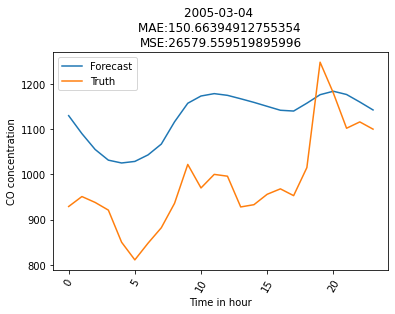

In [55]:
mae = mean_absolute_error(y_test.loc[forecast_start:forecast_end,['CO_sensor']], forecast_df['CO_sensor'])
mse = mean_squared_error(y_test.loc[forecast_start:forecast_end,['CO_sensor']], forecast_df['CO_sensor'])

plt.plot(forecast_df.index.hour, forecast_df['CO_sensor'], label='Forecast')
plt.plot(forecast_df.index.hour, y_test.loc[forecast_start:forecast_end,['CO_sensor']],  label='Truth');
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('Time in hour');
plt.ylabel('CO concentration');
plt.title(f'{forecast_df.index.min().date()} \nMAE:{mae} \nMSE:{mse}');